In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


# Install TensorFlow

import tensorflow as tf
import tensorflow_hub as hub


In [3]:
cna_efgr = pd.read_csv("../data/cna_ic50_Erlotinib_binary_resp.tsv",sep = "\t", index_col="COSMIC_ID")
cna_pacl = pd.read_csv("../data/cna_ic50_Paclitaxel_binary_resp.tsv",sep = "\t", index_col="COSMIC_ID")
cna_suni = pd.read_csv("../data/cna_ic50_Sunitinib_binary_resp.tsv",sep = "\t", index_col="COSMIC_ID")
cna_sora = pd.read_csv("../data/cna_ic50_Sorafenib_binary_resp.tsv",sep = "\t", index_col="COSMIC_ID")
cna_rapa = pd.read_csv("../data/cna_ic50_Rapamycin_binary_resp.tsv",sep = "\t", index_col="COSMIC_ID")


In [4]:
cna_multi_drug = pd.concat([cna_efgr, cna_pacl, cna_suni, cna_sora,cna_rapa], axis=0)

In [5]:
cna_multi_drug.head()

,Unnamed: 0,1,2,9,10,12,13,14,15,16,...,107161145,107985535,107986809,107987337,107987341,109731405,112441434,DRUG_ID,LN_IC50,BINARY_RESPONSE
COSMIC_ID,,,,,,,,,,,,,,,,,,,,,
1240128,0,-0.584963,0.415037,-0.584963,-0.584963,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.584963,0.000000,-4.320000,-4.320000,0.000000,0.000000,1,2.632372,R
1240173,1,0.000000,-0.415037,0.321928,0.321928,-0.415037,0.321928,0.000000,0.000000,-0.415037,...,0.000000,0.000000,0.321928,-4.320000,-4.320000,-0.415037,-0.415037,1,3.323416,R
1240181,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.584963,-1.584963,0.000000,0.000000,1,2.836213,R
1240182,3,0.000000,0.415037,0.415037,0.415037,0.415037,0.415037,0.000000,0.415037,-0.584963,...,0.000000,0.000000,0.000000,-1.584963,-4.320000,-0.584963,-0.584963,1,2.717111,R
1240183,4,-0.415037,0.000000,-1.000000,-1.000000,0.000000,0.000000,-0.415037,0.000000,-0.415037,...,0.321928,0.321928,0.000000,-4.320000,-4.320000,-0.415037,0.321928,1,0.508283,S


## Data Prep

In [6]:
len(cna_multi_drug)

cna_multi_drug = cna_multi_drug.drop('LN_IC50', axis=1)
cna_multi_drug = cna_multi_drug.drop('Unnamed: 0', axis=1)

cna_multi_drug.loc[(cna_multi_drug.BINARY_RESPONSE == 'S'),'BINARY_RESPONSE'] = 1
cna_multi_drug.loc[(cna_multi_drug.BINARY_RESPONSE == 'R'),'BINARY_RESPONSE'] = 0

cna_multi_drug.head()

,1,2,9,10,12,13,14,15,16,18,...,107133524,107161145,107985535,107986809,107987337,107987341,109731405,112441434,DRUG_ID,BINARY_RESPONSE
COSMIC_ID,,,,,,,,,,,,,,,,,,,,,
1240128,-0.584963,0.415037,-0.584963,-0.584963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.584963,0.000000,-0.584963,0.000000,-4.320000,-4.320000,0.000000,0.000000,1,0
1240173,0.000000,-0.415037,0.321928,0.321928,-0.415037,0.321928,0.000000,0.000000,-0.415037,-0.415037,...,0.000000,0.000000,0.000000,0.321928,-4.320000,-4.320000,-0.415037,-0.415037,1,0
1240181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.584963,-1.584963,0.000000,0.000000,1,0
1240182,0.000000,0.415037,0.415037,0.415037,0.415037,0.415037,0.000000,0.415037,-0.584963,0.000000,...,0.415037,0.000000,0.000000,0.000000,-1.584963,-4.320000,-0.584963,-0.584963,1,0
1240183,-0.415037,0.000000,-1.000000,-1.000000,0.000000,0.000000,-0.415037,0.000000,-0.415037,-0.415037,...,0.321928,0.321928,0.321928,0.000000,-4.320000,-4.320000,-0.415037,0.321928,1,1


In [7]:
# split data
train_data_set, dev_data_set, train_labels, dev_labels = train_test_split(cna_multi_drug, cna_multi_drug['BINARY_RESPONSE'], test_size=0.20, random_state=0)


## TF Prep

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_set.values, train_labels.values))
train_dataset = train_dataset.shuffle(len(train_data_set)).batch(1)

In [9]:
test_dataset = tf.data.Dataset.from_tensor_slices((dev_data_set.values, dev_labels.values))
test_dataset = test_dataset.shuffle(len(dev_data_set)).batch(1)

## Model Build

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.fit(train_dataset, epochs=10, steps_per_epoch=150)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train for 150 steps
Epoch 1/10
150/150 [==============================] - 2s 13ms/step - loss: 3.2298 - accuracy: 0.8000
Epoch 2/10
150/150 [==============================] - 1s 9ms/step - loss: 2.6898 - accuracy: 0.7667
Epoch 3/10
150/150 [==============================] - 1s 9ms/step - loss: 2.0237 - accuracy: 0.8400
Epoch 4/10
150/150 [==============================] - 1s 9ms/step - loss: 1.6687 - accuracy: 0.8133
Epoch 5/10
150/150 [==============================] - 1s 9ms/step - loss: 1.1151 - accu

In [12]:
model.evaluate(test_dataset, verbose=2, steps=len(dev_data_set))

388/388 - 1s - loss: 1.1217 - accuracy: 0.8376


[1.1216708801070705, 0.83762884]

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  3127040   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
Total params: 3,128,330
Trainable params: 3,128,330
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.save('cna_multi_model')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cna_multi_model/assets


## Saved Model as Layer

In [15]:
hub_url = "cna_multi_model/"
embed = hub.KerasLayer(hub_url, input_shape=(24429,), dtype=tf.float64, trainable=False)

In [16]:
cna_multi_base_model = tf.keras.Sequential([
    embed,
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In [17]:
cna_multi_base_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [18]:
history = cna_multi_base_model.fit(train_dataset, epochs=10, steps_per_epoch=150, validation_data=(test_dataset))

Train for 150 steps, validate for 388 steps
Epoch 1/10
150/150 [==============================] - 2s 12ms/step - loss: 0.6258 - accuracy: 0.7467 - val_loss: 0.4929 - val_accuracy: 0.9227
Epoch 2/10
150/150 [==============================] - 1s 7ms/step - loss: 0.4182 - accuracy: 0.9200 - val_loss: 0.3442 - val_accuracy: 0.9227
Epoch 3/10
150/150 [==============================] - 1s 7ms/step - loss: 0.4133 - accuracy: 0.8600 - val_loss: 0.3103 - val_accuracy: 0.9227
Epoch 4/10
150/150 [==============================] - 1s 7ms/step - loss: 0.2737 - accuracy: 0.9333 - val_loss: 0.2808 - val_accuracy: 0.9227
Epoch 5/10
150/150 [==============================] - 1s 7ms/step - loss: 0.3996 - accuracy: 0.8600 - val_loss: 0.2852 - val_accuracy: 0.9227
Epoch 6/10
150/150 [==============================] - 1s 7ms/step - loss: 0.3895 - accuracy: 0.8667 - val_loss: 0.2858 - val_accuracy: 0.9227
Epoch 7/10
150/150 [==============================] - 1s 7ms/step - loss: 0.4149 - accuracy: 0.8533 - v

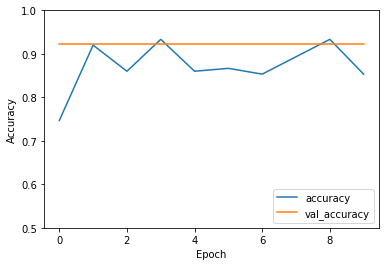

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [20]:
test_loss, test_acc = cna_multi_base_model.evaluate(test_dataset, verbose=2, steps=len(dev_data_set))

388/388 - 1s - loss: 0.2776 - accuracy: 0.9227


In [21]:
all_weights = []
for layer in cna_multi_base_model.layers:
   w = layer.get_weights()
   all_weights.append(w)

In [22]:
print(all_weights)

[[array([[-0.02188563, -0.05505143, -0.02452644, ..., -0.02035762,
        -0.00495448, -0.02122024],
       [ 0.02563255,  0.00730227, -0.01425694, ...,  0.00901372,
        -0.01500133, -0.03568049],
       [ 0.00240122, -0.00427468,  0.00629669, ...,  0.01550514,
         0.0199186 ,  0.00703753],
       ...,
       [ 0.01116017,  0.02424238,  0.00607994, ...,  0.02240865,
         0.00922578, -0.01493526],
       [-0.02823353,  0.02864152, -0.03658583, ..., -0.00513324,
         0.0051136 , -0.00647729],
       [ 0.03952872, -0.14213271, -0.03140109, ...,  0.00333496,
        -0.0093622 , -0.02736967]], dtype=float32), array([-0.01764893, -0.05035251, -0.04111337, -0.03039545, -0.00782196,
       -0.03275604, -0.01446583, -0.04729805, -0.03998357,  0.03946585,
       -0.02324899, -0.02872141, -0.0152532 , -0.03100219, -0.00998422,
       -0.02038559,  0.00506458,  0.0259544 , -0.00952329, -0.02717358,
       -0.01359447, -0.01307544, -0.01831827, -0.02050254, -0.065857  ,
       -0